Consider the Manufacturing Email data, which is given in the following format: each row ”a b t” denotes
a contact (a temporal link) between node a and b at time step t. This contact network is sampled/measured
once every 1 second. Thus, each time step has a duration of 1s, which is though not relevant for our analysis in
this assignment. We denote this temporal network as G<sub>data</sub>.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
with open('manufacturing_emails_temporal_network.xlsx', 'rb') as file:
    Gdata = pd.read_excel(file)

In [3]:
print(Gdata) ##Make sure we've read the data correctly

       node1  node2  timestamp
0          1      2          1
1          1      3          1
2          1      4          1
3          1      5          1
4          1      6          1
...      ...    ...        ...
82871      3     39      57787
82872      3     39      57788
82873     18     19      57789
82874      3     85      57790
82875     85     94      57791

[82876 rows x 3 columns]


# A. Explore properties of network G that is aggregated over all the T = 57791 steps.

Specifically, the aggregated network G is composed of all the nodes that have ever appeared in the dataset and any two nodes
are connected by a link if they have at least a contact over the whole period [0,T].
Compute the following topological properties of G in 1)-7) without considering the weight of any link and
the link weight property in 8).

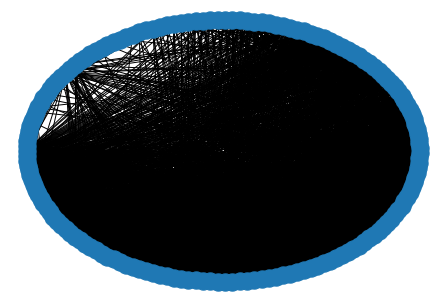

In [4]:
#We can now use networkx to help us:
#First we create the graph
aggregated_G = nx.from_pandas_edgelist(Gdata,"node1","node2")

nx.draw_shell(aggregated_G)

### 1) What is the number of nodes N, the number of links L, the average degree E[D] and standard deviation of the degree sqrt(Var[D])?

In [5]:
print("Number of Nodes:", aggregated_G.number_of_nodes())
print("Number of Links:", aggregated_G.number_of_edges())

average_deg = 0
for i in list(aggregated_G.nodes):
    average_deg += aggregated_G.degree[i]
average_deg /= aggregated_G.number_of_nodes()
print("Average degree:", average_deg)

std_deg = 0
for i in list(aggregated_G.nodes):
    std_deg += (aggregated_G.degree[i] - average_deg)**2
std_deg /= aggregated_G.number_of_nodes()
std_deg = std_deg ** 0.5
print("Standard deviation of the degree: ", std_deg)

Number of Nodes: 167
Number of Links: 3250
Average degree: 38.92215568862275
Standard deviation of the degree:  31.525295235166052


### 2) Plot the degree distribution. Which network model, Erdös-Rényi (ER) random graphs or scale-free networks, could better model this network with respect to degree distribution? Why?  

Text(0, 0.5, 'Frequency')

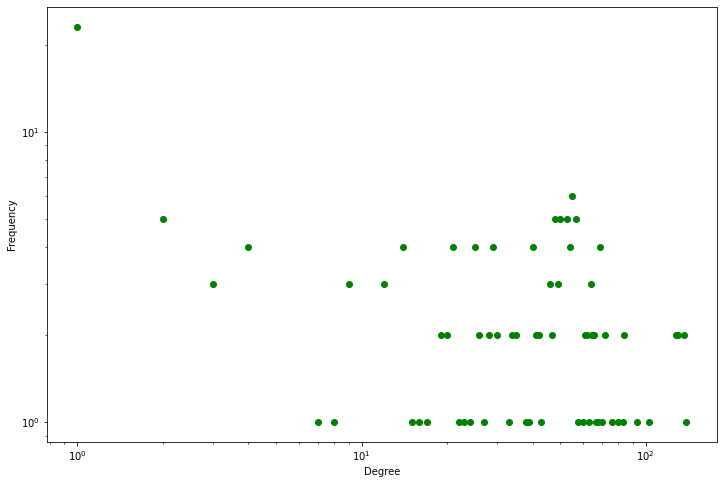

In [6]:
degree_freq = nx.degree_histogram(aggregated_G)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees, degree_freq,'go') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

### 3) What is the degree correlation (assortativity) ρ<sub>D</sub>? What is its physical meaning?

In [7]:
print("Degree correlation:", nx.degree_assortativity_coefficient(aggregated_G))

Degree correlation: -0.29517729789301855


Answer: The physical meaning is that nodes with different degrees are related

### 4) What is the clustering coefficient C?

In [8]:
print("Clustering Coefficient: ", nx.average_clustering(aggregated_G))

Clustering Coefficient:  0.5918632085486949


### 5) What is the average hopcount E[H] of the shortest paths between all node pairs? What is the diameter H<sub>max</sub>?

In [9]:
print("Average hopcount: ", nx.average_shortest_path_length(aggregated_G))
print("Diameter: ", nx.diameter(aggregated_G))

Average hopcount:  1.9673905201644903
Diameter:  5


### 6) Has this network the small-world property? Justify your conclusion quantitatively (Hint: Lecture 2).

### 7) What is the largest eigenvalue (spectral radius) λ<sub>1</sub> of the adjacency matrix?

In [10]:
L = nx.normalized_laplacian_matrix(aggregated_G)
e = np.linalg.eigvals(L.A)
print("Largest eigenvalue:", max(e))

Largest eigenvalue: 1.7133206272406944


### 8) Consider further the weight of each link in G, which is the total number of contacts between the corresponding two nodes within [0,T]. Plot the probability density function (distribution) of the link weight (Choose the scales of the two axes and the bins/bin-size for the distribution such that the plot is insightful for interpretation). 
### The probability density function f<sub>W</sub>(x) of the weight W of a link is defined as f<sub>W</sub>(x) = lim<sub>∆x→0</sub> Pr[x<W≤x+∆x]/∆x , the probability that the variable (or the percentage of links whose weight) is within each range or bin (x,x+ ∆x] normalized by the size of the bin ∆x. Does W follow a power-law distribution? Why?

Hint: All metrics computed for the network G are recommended to put into a table.

# B. Information spreading on a temporal network

We consider the following information spreading process, which is actually a simplified Susceptible-Infected
model but on a temporal network. Initially, at time t = 0, a single node s is infected meaning that this
node possesses the information whereas all the other nodes are Susceptible, thus have not yet perceived the
information. Node s is also called the seed of the information. Whenever an infected node i is in contact with
a susceptible node j at any time step t, the susceptible node becomes infected during the same time step and
could possibly infect other nodes only since the next time step via its contacts with susceptible nodes. Once a
node becomes infected, it stays infected forever. For example, assume that the seed node has its first contact at
time t = 5 and that contact is with node m. Although node s gets infected since t = 0, it infects a second node,i.e. node m only at t = 5 when it contacts m. Infection happens only when an infected node and a susceptible node are in contact. The number of infected nodes is non-decreasing over time.

Simulate the information spreading process on the given temporal network Gdata for N iterations. Each
iteration starts with a different seed node infected at t = 0 and ends at t = T = 57791 the last time step that
the network is measured. Via the N iterations, we consider the spreading process that starts at every node
i ∈[1,N]. Record the number of infected nodes I(t) over time t for each iteration.

In [11]:
G_temp = nx.from_pandas_edgelist(Gdata,"node1","node2")
temporal_edge_list = Gdata.to_records(index=False)
temporal_edge_list = list(temporal_edge_list)
T = 57791
def infection(N):
    
    nx.set_node_attributes(G_temp,False,"infected")
    G_temp.nodes[N]["infected"] = True
    infected_nodes_over_time = [0 for i in range(T)]
    
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        if G_temp.nodes[node1]["infected"] and not G_temp.nodes[node2]["infected"]:
            G_temp.nodes[node2]["infected"] = True
            infected_nodes_over_time[timestamp-1] += 1
        elif G_temp.nodes[node2]["infected"] and not G_temp.nodes[node1]["infected"]:
            G_temp.nodes[node1]["infected"] = True
            infected_nodes_over_time[timestamp-1] += 1
    return np.cumsum(infected_nodes_over_time)

### 9) Taking all the N iterations into count, plot the average number of infected nodes E[I(t)] together with its error bar (standard deviation sqrt(Var[I(t)]) as a function of the time step t.

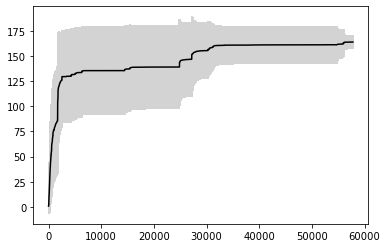

In [12]:
T = 57791
means_list = []
variance_list = []

total_num_infected_at_time_t = []
for i in range(1, G_temp.number_of_nodes()+1):
    total_num_infected_at_time_t.append(infection(i))
    
total_num_infected_at_time_t = np.asarray(total_num_infected_at_time_t)
    
mean = np.mean(total_num_infected_at_time_t,axis=0)
std = np.std(total_num_infected_at_time_t,axis=0)

plt.errorbar(range(1,T+1),mean,yerr=std,color='black',
             ecolor='lightgray')
plt.show()

### 10) How influential a node is as a seed node could be partially reflected by the time it takes to reach/infect 75% of the total nodes when this node is selected as the seed node. The shorter the time is, the more influential the seed node is. Using this standard to rank the influence of all the nodes and record the ranking in a vector R = [R(1),R(2),...,R(N)] where R(i) is the node index of the i −th most influential seed node and R(1) is the most influential node that infects 75% nodes in the shortest time. Note that you don’t need to provide this vector in your report.

In [13]:
array_timestamps = []
for node in total_num_infected_at_time_t:
    array_timestamps.append(np.argwhere(node > 0.75 * G_temp.number_of_nodes())[0][0])
indeces = np.argsort(array_timestamps)
print(indeces+1)

[  1  92  91  90  89  88  87  86  85  83  82  81  80  79  78  77  76  75
  74  73  72  71  70  69  68  67  66  65  93  64  94  96 123 122 121 120
 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102
 101 100  99  98  97  95  63  84  61  29  28  27  26  25  24  23  22  21
  20  19  18  17  30  16  14  13  12  11  62   9   8   7   6   5   4   3
   2  15  31  10  33  60  59  58  57  56  55  54  53  52  51  50  48  47
  49  45  34  35  36  46  38  39  37  32  41  42  43  44  40 124 125 126
 127 128 129 130 131 132 133 134 135 146 145 144 143 142 140 147 139 138
 137 136 141 148 149 150 151 152 153 157 156 158 154 160 161 162 159 163
 164 165 166 155 167]


### 11) We are going to explore which nodal level network feature in the aggregated network G could well suggest the nodal influence discussed in 10). Compute the degree and strength<sup>2</sup> of each node in the aggregated network G and rank the importance of the nodes according to these two centrality metrics respectively. You obtain the ordered vector D = [D(1),D(2),...,D(N)] and S = [S(1),S(2),...,S(N)], where D(i) is the node having the i −th highest degree and S(i) is the node with the i −th highest strength. How precisely a centrality metric e.g. the degree could predict seed nodes’ influence could be quantified by the top f recognition rate rRD(f) = |Rf ∩Df ||Rf | where Rf and Df are the sets of nodes ranking in the top f fraction according to their influence and degree respectively and |Rf| = fN is the number of nodes in Rf. Plot rRD(f) and rRS(f) as a function of f where f = 0.05,0.1,0.15,...,0.5. Which metric, the degree or the strength could better predict the influence of the nodes? Why?

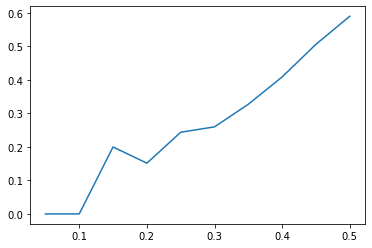

In [14]:
degrees = []
strength = []
for node in aggregated_G:
    degrees.append(aggregated_G.degree[node])

D = np.argsort(-np.asarray(degrees))+1 #sorted from highest degree to lowest
rRDf = []
for f in np.arange(0.05,0.55,0.05):
    sliced_D = set(D[:int(f*len(D))])
    sliced_R = set(indeces[:int(f*len(D))])
    rRDf.append(len(sliced_D.intersection(sliced_R))/len(sliced_R))

plt.plot(np.arange(0.05,0.55,0.05),rRDf)
plt.show()

### 12) Consider the third nodal property, i.e., the time Z when a node has its first contact in the network, and use this metric to predict nodes’ influence. Compare this nodal property and the two features proposed in question 11): which feature better/badly reflects how influential a node is and why? Hint: Similar to 11) plot r<sub>RZ</sub>(f) as a function of f for the feature Z

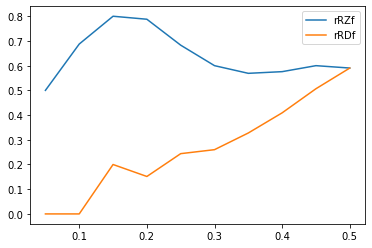

In [17]:
array_timestamps = []
for node in total_num_infected_at_time_t:
    array_timestamps.append(np.argwhere(node > 1)[0][0])
Z = np.argsort(array_timestamps) + 1

rRZf = []
for f in np.arange(0.05,0.55,0.05):
    sliced_Z = set(Z[:int(f*len(D))])
    sliced_R = set(indeces[:int(f*len(D))])
    rRZf.append(len(sliced_D.intersection(sliced_R))/len(sliced_R))
    
plt.plot(np.arange(0.05,0.55,0.05),rRZf,label="rRZf")
plt.plot(np.arange(0.05,0.55,0.05),rRDf,label="rRDf")
plt.legend()
plt.show()

### 13) How influential a node j is as a seed node can be also reflected by the average time E[τ(j)] = sum<sub>i∈M</sub> τi(j)/0.75N for the information starts from the seed j at t = 0 to reach the nodes that belong to the set M and the set M contains the 75% ·N nodes that are reached earliest in time by the information starts at seed j. Note that τi(j) denotes that time when node i gets infected and j is the seed node. Use this standard to rank the influence of all the nodes and record the ranking in a vector R′ = [R′(1),R′(2),...,R′(N)]. Which metric, R, the degree D, the strength S or the time of first contact Z, could better predict the influence ranking R′ ? Hint: use the method proposed in 11); Influence standard in 13) considers the average time to infect a node in M whereas the influence standard in 10) considers the time to infect all the nodes in M.

# C. Influence of temporal network features on information spreading.

### 14) Construct the following three temporal networks. G2 is exactly the same as Gdata except that the time stamps describing when each temporal link (contact) appears in Gdata are randomised in G2. In other words, G2 is constructed by copying all the temporal links {(a,b,t)} from Gdata but their time stamps t are randomly re-shuffled. The number of contacts between each node pair is the same between Gdata and G2. [A time stamp vector v, whose length equals the number of contacts, can be randomly reshuffled to a vector v2 of the same length by assigning each element in v to a randomly selected position in vector v2 while avoiding more than one elements from v assigned to the same position in v2]. G3 is constructed by the following steps: G∗3 has the same topology as G, which is an unweighted network. Secondly, G3 is obtained by assigning the set of timestamps in Gdata to the links in G∗3, randomly. A link in G∗3 may receive more than one time stamps, meaning that the two nodes contact more than once. A link in G∗3 receives no time stamp means that there is no contact between the corresponding two nodes. G3 is a temporal network composed of all these contacts and has the same number of contacts as Gdata and G2. 

Plot the probability density function (distribution) of the inter-arrival time of two consecutive contacts
between a node pair for each of these three networks Gdata, G2 and G3. Hint: For each network, collect the
inter-arrival time (time difference) between every two consecutive contacts along each node pair that has at
least two contacts and make the corresponding histogram. For a node pair that has 5 contacts, you can collect
4 inter-arrival times. How do the three networks differ from each other? Please interpret your observation.

### 15) Simulate exactly the same information spreading process on G2 and G3 as described in B. On each temporal network, N iterations of the spreading processes are simulated and each iteration starts at a different seed node. Plot the average number of infected nodes E[I(t)] and the standard deviation sqrt(Var[I(t)]) as a function of the time step t for Gdata, G2 and G3 respectively. Compare and rank the information spreading performance (e.g. prevalence or speed of the spread) on these three temporal networks. Interpret/explain your observation. E.g. which temporal network features could possibly explain the different spreading performance?